# Visualization of Tree-Ring Watermark's Generation for ImageNet-Guided Diffusion


In [1]:
# Package imports
import torch
import numpy as np
import matplotlib.pyplot as plt

# Relative imports
from guided_diffusion import *
from tree_ring import *
from metrics import *
from utils import *

# Experiment name
experiment_name = "Vis_Tree_Ring_Gen_Guided"

# Experiment parameters
image_size = 64
labels = [8, 21, 42]
tree_ring_paras = dict(
    w_channel=2,
    w_pattern="ring",
    w_mask_shape="circle",
    w_radius=10,
    w_measurement="l1_complex",
    w_injection="complex",
)
# Parse the number of DDIM steps, which is 50 by default
num_ddim_steps = int(
    get_default_guided_diffusion_paras(image_size)["timestep_respacing"][4:]
)
# Seeds
diffusion_seed = 0
message_seed = 0
key_seed = 0  # not affecting the results since we have only one key

# Device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Implement Tree-Ring Watermark for ImageNet-Guided Diffusion Models


In [2]:
# Load guided diffusion models which are class-conditional diffusion models trained on ImageNet
model, diffusion = load_guided_diffusion_model(image_size, device)


# Generate images without watermark
images_wo = guided_ddim_sample(
    model,
    diffusion,
    labels,
    image_size,
    diffusion_seed=diffusion_seed,
    return_image=True,
)

# Generate one watermark message (which is the key in tree-ring's paper)
message = generate_guided_tree_ring_message(
    message_seed=message_seed,
    image_size=image_size,
    tree_ring_paras=tree_ring_paras,
    device=device,
)

# Generate one watermark key (which is the mask in tree-ring's paper)
key = generate_guided_tree_ring_key(
    key_seed=key_seed,
    image_size=image_size,
    tree_ring_paras=tree_ring_paras,
    device=device,
)

# Generate images with watermark
images_w = guided_ddim_sample_with_tree_ring(
    model,
    diffusion,
    labels,
    keys=key,
    messages=message,
    tree_ring_paras=tree_ring_paras,
    image_size=image_size,
    diffusion_seed=diffusion_seed,
    return_image=True,
)

# Reverse diffusion on images with and without watermark
reversed_latents_wo = guided_reverse_ddim_sample(
    model, diffusion, images=images_wo, image_size=image_size, return_image=True
)
reversed_latents_w = guided_reverse_ddim_sample(
    model, diffusion, images=images_w, image_size=image_size, return_image=True
)

# Detect and evaluate watermark
distances_wo, distances_w = detect_guided_tree_ring(
    reversed_latents_wo,
    reversed_latents_w,
    keys=key,
    messages=message,
    tree_ring_paras=tree_ring_paras,
    image_size=image_size,
)
acc, auc, low = evaluate_detection(distances_wo, distances_w)
print(
    f"Sanity check when there is no attack: ACC={acc}, AUC={auc}, and TPR@1%FPR={low}"
)

Sanity check when there is no attack: ACC=1.0, AUC=1.0, and TPR@1%FPR=1.0


## How Tree-Ring Watermarks are Changing through Forward Diffusion Sampling


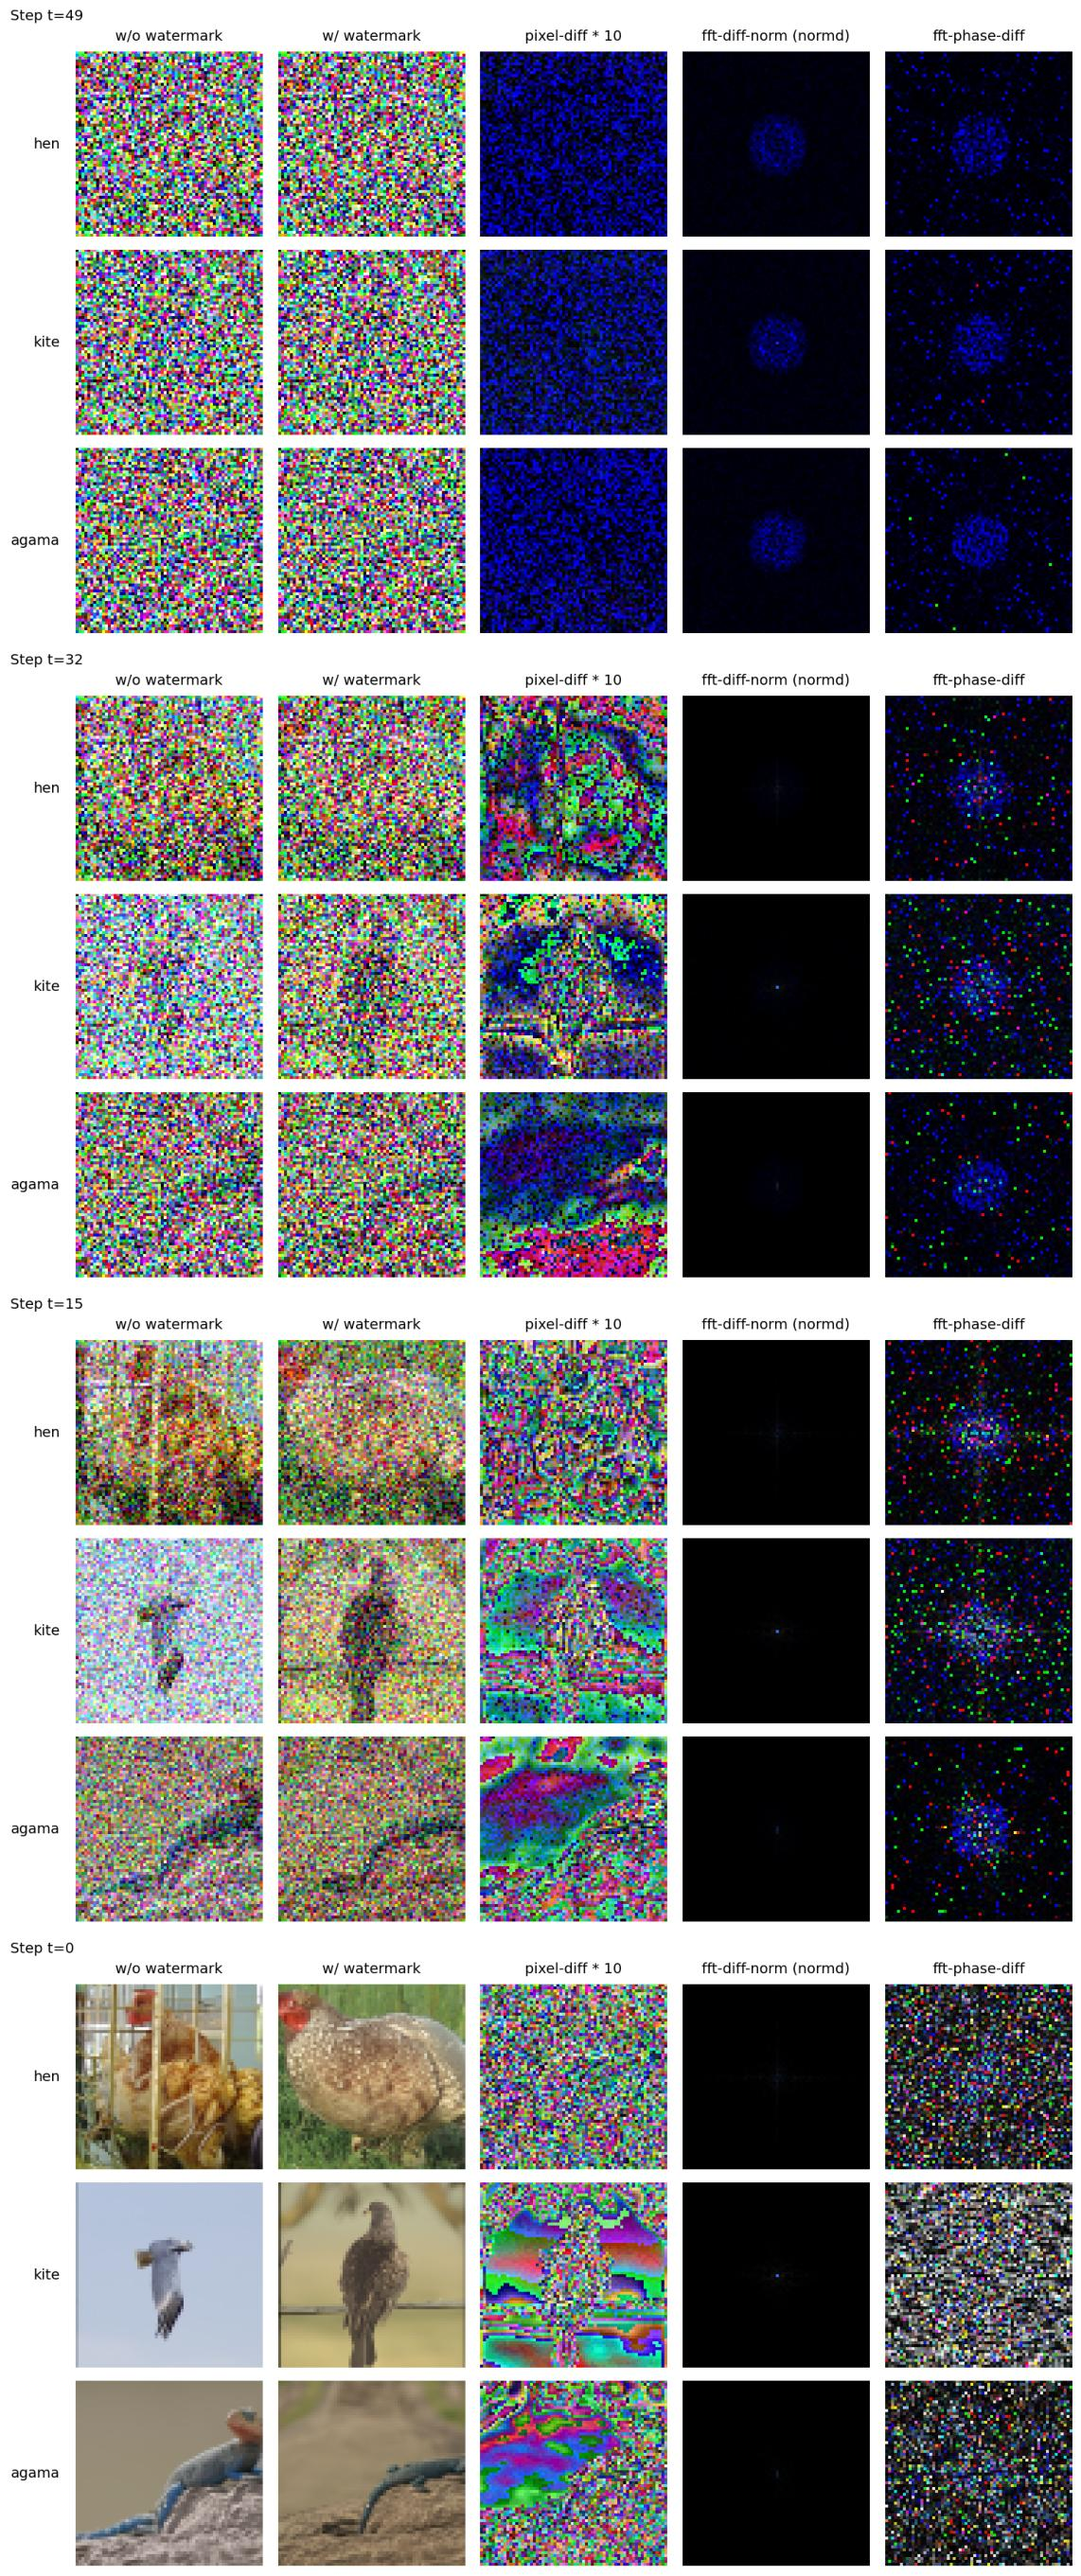

In [3]:
# Get iterators for guided diffusion with and without watermark
images_prog_wo = guided_ddim_sample(
    model,
    diffusion,
    labels,
    image_size=image_size,
    diffusion_seed=diffusion_seed,
    progressive=True,
    return_image=True,
)
images_prog_w = guided_ddim_sample_with_tree_ring(
    model,
    diffusion,
    labels,
    keys=key,
    messages=message,
    tree_ring_paras=tree_ring_paras,
    image_size=image_size,
    diffusion_seed=diffusion_seed,
    progressive=True,
    return_image=True,
)

# Guided diffusion with and without watermark together step by step
figs = []
ddim_step_t = num_ddim_steps - 1
for images_wo, images_w in zip(images_prog_wo, images_prog_w):
    # Unnormalize images
    images_wo_tensor = to_tensor(images_wo)
    images_w_tensor = to_tensor(images_w)
    # Pixel-wise diff between images with and without watermark
    pixel_diff = torch.abs(images_wo_tensor - images_w_tensor)
    # FFT diff between images with and without watermark
    images_wo_fft = torch.fft.fftshift(torch.fft.fft2(images_wo_tensor), dim=(-1, -2))
    images_w_fft = torch.fft.fftshift(torch.fft.fft2(images_w_tensor), dim=(-1, -2))
    fft_diff_norm = torch.abs(images_wo_fft - images_w_fft)
    fft_phase_diff = (
        torch.remainder(
            torch.abs(
                torch.atan2(images_wo_fft.imag, images_wo_fft.real)
                - torch.atan2(images_w_fft.imag, images_w_fft.real)
            ),
            np.pi,
        )
        / np.pi
    )
    figs.append(
        visualize_image_grid(
            [
                images_wo,
                images_w,
                to_pil(pixel_diff * 10, norm_type=None),
                to_pil(fft_diff_norm / fft_diff_norm.max(), norm_type=None),
                to_pil(fft_phase_diff, norm_type=None),
            ],
            col_headers=[
                "w/o watermark",
                "w/ watermark",
                "pixel-diff * 10",
                "fft-diff-norm (normd)",
                "fft-phase-diff",
            ],
            row_headers=get_imagenet_class_names(labels),
            fontsize=10,
            column_first=True,
            title=f"Step t={ddim_step_t}",
        )
    )
    ddim_step_t -= 1

# Concate selected figures into one and show
concatenate_images(
    [figs[0:-1:17] + [figs[-1]]],
    save_path=f"./results/{experiment_name}/forward_diffusion.jpg",
    display=True,
)
# Make gif from the figures
make_gif(
    figs,
    save_path=f"./results/{experiment_name}/forward_diffusion.gif",
    display=False,
)

# Closing
plt.close("all")